## Imporerer pakker

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, f1_score, log_loss, confusion_matrix

from sklearn.compose import TransformedTargetRegressor

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor


# Classification Models
from sklearn.linear_model import LogisticRegression, HuberRegressor, BayesianRidge, LassoLars, PassiveAggressiveRegressor, TheilSenRegressor, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Other Model Utilities
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import plot_tree

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
from sklearn import set_config
import plotly.express as px
from sklearn.compose import TransformedTargetRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import TransformedTargetRegressor
from scipy import stats
from xgboost import XGBRegressor
from sklearn.preprocessing import TargetEncoder
import shap
from sklearn.preprocessing import MinMaxScaler
import pickle

## Laster inn filer

In [34]:
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('validation_df.csv')
test_df = pd.read_csv('test_df.csv')

pd.set_option('display.max_columns', None)
pd.reset_option('display.float_format')

## Variabelutvinning

In [35]:

numeric_cols = [
        'alder', 'utdanning', 'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens', 
        'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon', 'serumalbumin', 
        'bilirubin', 'kreatinin', 'natrium', 'blod_ph', 
        'antall_komorbiditeter', 'koma_score', 'fysiologisk_score', 
        'apache_fysiologisk_score', 'overlevelsesestimat_2mnd' ,'overlevelsesestimat_6mnd', 
        'lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd', 'diabetes', 
        'glukose', 'blodurea_nitrogen', 'urinmengde','dødsfall' ,'sykehusdød',
        'demens'
    ]
categorical_cols = ['kjønn', 'etnisitet', 'sykdomskategori_id', 'sykdomskategori', 
                        'sykdom_underkategori', 'dnr_status',
                     'inntekt', 'kreft']

colsNotIncluded = set(train_df.columns) - set(numeric_cols) - set(categorical_cols)
print(colsNotIncluded)

{'adl_stedfortreder', 'adl_pasient', 'oppholdslengde'}


## Pipeline

In [36]:
def process_adl(df):
    # Combine ADL columns
    df['adl'] = df['adl_pasient'].combine_first(df['adl_stedfortreder'])

    # Create 'ADL_no' column where 'ADL' is NaN and 'oppholdslengde' is less than 7 days
    df['adl_no'] = df['adl'].isna() & (df['oppholdslengde'] < 7)

    # Drop original ADL columns
    df = df.drop(columns=['adl_pasient', 'adl_stedfortreder'])
    
    return df

def create_severity_indicators(df):
    df['alvorlighetsgrad_høy'] = (df['fysiologisk_score'] > 60).astype(bool)
    df['alvorlighetsgrad_lav'] = (df['fysiologisk_score'] < 10).astype(bool)
    df['alvorlighetsgrad_middels'] = ((df['fysiologisk_score'] >= 10) & (df['fysiologisk_score'] <= 60)).astype(bool)
    return df

In [37]:
def prepare_data_for_prediction(df, categorical_cols, numeric_cols):
    # Step 1: Process ADL (if relevant for the new input)
    df = process_adl(df)

    # Step 2: Create severity level indicators
    df = create_severity_indicators(df)
    
    # Step 3: Additional features (e.g., interaction terms, ratios)
    df['alder_fysiologisk_interaction'] = df['alder'] * df['fysiologisk_score']
    df['bilirubin_kreatinin_ratio'] = df['bilirubin'] / df['kreatinin']
    
    # Example of binning age
    df['age_binned'] = pd.cut(df['alder'], bins=[0, 30, 60, np.inf], labels=['young', 'middle-aged', 'senior'])
    
    # Step 4: Extract the target column (e.g., 'oppholdslengde')
    y = df['oppholdslengde']  # Assuming 'oppholdslengde' is the target variable
    df = df.drop(columns=['oppholdslengde'])  # Drop the target from the DataFrame

    # Additional columns to treat as categorical or numeric
    additional_numeric_cols = ['alder_fysiologisk_interaction', 'bilirubin_kreatinin_ratio']
    additional_categorical_cols = ['age_binned']

    # Combine all numeric and categorical features
    numeric_cols_all = numeric_cols + additional_numeric_cols
    categorical_cols_all = categorical_cols + additional_categorical_cols

    # Return the modified DataFrame, numeric, and categorical columns
    return df, numeric_cols_all, categorical_cols_all, y


In [38]:
X_train, numeric_cols_train, categorical_cols_train, y_train = prepare_data_for_prediction(train_df, categorical_cols, numeric_cols)
X_val, numeric_cols_val, categorical_cols_val, y_val = prepare_data_for_prediction(val_df, categorical_cols, numeric_cols)
X_test, numeric_cols_test, categorical_cols_test, y_test = prepare_data_for_prediction(test_df, categorical_cols, numeric_cols)

In [39]:
# Pipeline for numeric and categorical preprocessing
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer()),  # Placeholder for numeric imputation
    ('scaler', StandardScaler())  # Scaling for numeric features
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),  # Categorical imputation
    ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encoding
])

# ColumnTransformer for applying preprocessing pipelines
col_transformer = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, numeric_cols_train),  # Numeric pipeline for numeric columns
    ('cat_pipeline', cat_pipeline, categorical_cols_train)  # Categorical pipeline for categorical columns
])

# Apply the pipeline to fit/transform the data
X_train_imputed = col_transformer.fit_transform(X_train)
X_val_imputed = col_transformer.transform(X_val)
X_test_imputed = col_transformer.transform(X_test)

# Optional: Convert the imputed data back to a DataFrame for easy handling of feature names
feature_names = list(numeric_cols_train) + list(col_transformer.named_transformers_['cat_pipeline'].named_steps['one-hot-encoder'].get_feature_names_out(categorical_cols_train))
X_train_imputed = pd.DataFrame(X_train_imputed, columns=feature_names)
X_val_imputed = pd.DataFrame(X_val_imputed, columns=feature_names)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=feature_names)

## Grunnlinjemodeller

In [40]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
prediction = baseline.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

21.59611100410102

In [41]:
baseline2 = DummyRegressor(strategy='median')
baseline2.fit(X_train, y_train)
prediction = baseline2.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

22.712103715253104

In [42]:
X_train_imputed

,alder,utdanning,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,antall_komorbiditeter,koma_score,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,diabetes,glukose,blodurea_nitrogen,urinmengde,dødsfall,sykehusdød,demens,alder_fysiologisk_interaction,bilirubin_kreatinin_ratio,kjønn_female,kjønn_male,etnisitet_asian,etnisitet_black,etnisitet_hispanic,etnisitet_other,etnisitet_white,sykdomskategori_id_A1s,sykdomskategori_id_BrY,sykdomskategori_id_ChE,sykdomskategori_id_DWw,sykdomskategori_ARF/MOSF,sykdomskategori_COPD/CHF/Cirrhosis,sykdomskategori_Cancer,sykdomskategori_Coma,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,inntekt_8.0,inntekt_20.0,inntekt_35.0,kreft_metastatic,kreft_no,kreft_yes,age_binned_middle-aged,age_binned_senior,age_binned_young
0,0.136098,0.000000,-0.434865,0.552129,0.878805,0.173356,-0.491644,0.643776,-1.602932,0.184687,0.007891,1.899193,7.653467e-02,-1.399134,-0.497298,0.038981,0.305671,0.301262,0.404534,0.681849,1.104765e+00,-0.498961,-0.814194,0.424970,-0.800255,-1.472822,-0.598903,-0.182243,0.134112,0.036828,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.200370,0.000000,-0.832064,-0.423753,-1.173283,0.696944,-0.094572,-0.448561,-1.602932,-0.314497,-0.760562,0.243665,1.055552e+00,-1.399134,0.534664,-0.757879,-0.342761,0.768683,0.977812,1.051397,1.467138e+00,-0.498961,0.000000,-0.581604,0.154715,-1.472822,-0.598903,-0.182243,-0.562402,-0.036876,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.071826,0.742411,0.648404,-0.689705,-1.047001,0.068638,-0.969369,0.675711,0.315403,-0.382567,-0.642350,-0.087441,-1.254099e-14,0.104890,-0.497298,-0.728308,-1.140831,0.213529,-0.482704,1.051397,3.800186e-01,-0.498961,0.000000,-0.581604,0.154715,0.678969,-0.598903,-0.182243,-0.585989,-0.325825,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.071826,0.742411,-0.290429,-0.357048,-0.131454,-0.769103,-0.652951,0.675711,0.443416,-0.244145,-0.459047,0.409218,-1.254099e-14,-0.647122,-0.140080,-0.996976,-1.190711,0.740413,0.357560,0.681849,-7.071005e-01,-0.498961,0.000000,-0.581604,0.154715,0.678969,-0.598903,-0.182243,-0.825502,-0.176349,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.071826,0.098945,-0.868173,-0.046698,0.720952,0.696944,-1.211337,-0.880416,0.443416,4.472541,4.204651,0.243665,-6.404882e-01,-0.647122,-0.140080,0.935449,0.305671,-0.592881,-0.588636,-0.796344,-7.071005e-01,-0.498961,0.107816,2.696082,-2.346063,0.678969,-0.598903,-0.182243,0.897225,0.329195,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,-0.763708,-3.761852,0.684513,-0.490132,-0.983860,0.278073,-0.336540,0.675711,0.443416,-0.244145,-0.642350,0.243665,-1.254099e-14,0.104890,-0.497298,0.098512,-0.193123,-0.070140,-0.027341,0.000000,2.011574e-16,-0.498961,1.168127,0.167863,-0.549475,-1.472822,-0.598903,-0.182243,-0.328639,-0.021860,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0

## Modellering

## Visualisering av actual vs predicted

In [43]:
def plot_actual_vs_pred(y_actual, y_pred, model_name):
    df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
    fig = px.scatter(df, x='Actual', y='Predicted', title=f"{model_name}: Actual vs. Predicted")
    fig.add_shape(type="line", x0=df['Actual'].min(), y0=df['Actual'].min(),
                  x1=df['Actual'].max(), y1=df['Actual'].max(), line=dict(color='Red', dash='dash'))
    fig.show()


## RandomForestRegression

In [44]:
model_rf = RandomForestRegressor(n_estimators=200, max_depth=50, random_state=42)
model_rf.fit(X_train_imputed, y_train)

# Evaluate the model on validation data
y_val_pred_rf = model_rf.predict(X_val_imputed)
rmse_val_rf = (root_mean_squared_error(y_val, y_val_pred_rf))
print(f"RMSE on Validation Set (RandomForest): {rmse_val_rf:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_rf, "Random Forest with Target Encoding")

RMSE on Validation Set (RandomForest): 20.583


## ExtraTreesRegressor

In [45]:
# Define and train ExtraTrees model
model_et = ExtraTreesRegressor(n_estimators=200, random_state=42)
model_et.fit(X_train_imputed, y_train)

# Evaluate on validation data
y_val_pred_et = model_et.predict(X_val_imputed)
rmse_val_et = (root_mean_squared_error(y_val, y_val_pred_et))
print(f"RMSE on Validation Set (ExtraTrees): {rmse_val_et:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_et, "Random Forest with Target Encoding")

RMSE on Validation Set (ExtraTrees): 20.287


## GradientBoostingRegressor

In [46]:
# Define and train ExtraTrees model
model_gb = GradientBoostingRegressor(n_estimators=200, random_state=42)
model_gb.fit(X_train_imputed, y_train)

# Evaluate on validation data
y_val_pred_gb = model_gb.predict(X_val_imputed)
rmse_val_gb = (root_mean_squared_error(y_val, y_val_pred_gb))
print(f"RMSE on Validation Set (ExtraTrees): {rmse_val_gb:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_gb, "Random Forest with Target Encoding")

RMSE on Validation Set (ExtraTrees): 20.474


In [47]:
from sklearn.model_selection import RandomizedSearchCV

X_train_full = X_train_imputed
X_val_full = X_val_imputed

# Define the parameter grid for ExtraTreesRegressor
param_grid_et = {
    'n_estimators': [100, 200, 500],  # Number of trees
    'max_depth': [10, 20, 50, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Initialize RandomizedSearchCV for ExtraTreesRegressor
random_search_et = RandomizedSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_distributions=param_grid_et,
    n_iter=50,  # Number of random parameter combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search model on the full feature set (X_train_full)
random_search_et.fit(X_train_full, y_train)

# Best hyperparameters
print(f"Best Hyperparameters: {random_search_et.best_params_}")

# Best RMSE score
best_rmse = -random_search_et.best_score_
print(f"Best RMSE Score: {best_rmse:.3f}")

# After finding the best model, use it to predict on the validation set
best_et_model = random_search_et.best_estimator_

# Predict on the validation set (with full features)
y_val_pred_best_et = best_et_model.predict(X_val_full)

# Calculate RMSE for the full feature set
rmse_best_et = root_mean_squared_error(y_val, y_val_pred_best_et)
print(f"RMSE on Validation Set with Full Features: {rmse_best_et:.3f}")

# Call the plot_actual_vs_pred function to visualize actual vs predicted values
plot_actual_vs_pred(y_val, y_val_pred_best_et, "Best ExtraTreesRegressor with Full Features")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators

In [48]:
from sklearn.model_selection import GridSearchCV

# Use the best parameters as the center of the grid
param_grid_et_refined = {
    'n_estimators': [150, 200, 250],  # Around 200
    'max_depth': [40, 50, 60],        # Around 50
    'min_samples_split': [8, 10, 12], # Around 10
    'min_samples_leaf': [3, 4, 5],    # Around 4
    'bootstrap': [True]               # Keep as True based on RandomizedSearch result
}

# Initialize GridSearchCV for ExtraTreesRegressor
grid_search_et = GridSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_grid=param_grid_et_refined,
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search model on the full feature set (X_train_full)
grid_search_et.fit(X_train_full, y_train)

# Best hyperparameters from GridSearch
print(f"Best Hyperparameters from GridSearch: {grid_search_et.best_params_}")

# Best RMSE score from GridSearch
best_rmse_grid = -grid_search_et.best_score_
print(f"Best RMSE Score from GridSearch: {best_rmse_grid:.3f}")

# After finding the best model, use it to predict on the validation set
best_et_model_grid = grid_search_et.best_estimator_

# Predict on the validation set (with full features)
y_val_pred_best_et_grid = best_et_model_grid.predict(X_val_full)

# Calculate RMSE for the full feature set
rmse_best_et_grid = root_mean_squared_error(y_val, y_val_pred_best_et_grid)
print(f"RMSE on Validation Set with Full Features (GridSearch): {rmse_best_et_grid:.3f}")

# Visualize actual vs predicted values
plot_actual_vs_pred(y_val, y_val_pred_best_et_grid, "Best ExtraTreesRegressor with Full Features (GridSearch)")

with open('best_et_model_top68.pkl', 'wb') as f:
    pickle.dump(best_et_model_grid, f)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=150; total time=   5.7s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=150; total time=   5.8s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=150; total time=   5.8s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=150; total time=   5.8s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=150; total time=   5.8s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   7.7s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   7.9s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   8.0s
[C

In [52]:
# Get feature importances from the best model after GridSearch
importances = best_et_model_grid.feature_importances_

# Create a DataFrame to display feature importances with the correct features
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # Use the feature names from X_train_full
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
feature_importance_df.T


,45,16,19,26,17,18,15,20,8,25,11,4,13,0,6,5,2,3,14,12,7,1,28,61,55,10,62,21,31,30,23,59,56,57,36,22,29,24,9,33,41,37,39,43,60,46,63,42,38,58,47,32,34,50,40,44,27,48,52,51,49,53,54,35
Feature,sykdom_underkategori_ARF/MOSF w/Sepsis,apache_fysiologisk_score,lege_overlevelsesestimat_2mnd,sykehusdød,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,fysiologisk_score,lege_overlevelsesestimat_6mnd,serumalbumin,dødsfall,natrium,hjertefrekvens,antall_komorbiditeter,alder,kroppstemperatur,respirasjonsfrekvens,blodtrykk,hvite_blodlegemer,koma_score,blod_ph,lungefunksjon,utdanning,alder_fysiologisk_interaction,age_binned_middle-aged,inntekt_8.0,kreatinin,age_binned_senior,diabetes,kjønn_male,kjønn_female,blodurea_nitrogen,kreft_no,inntekt_20.0,inntekt_35.0,etnisitet_white,glukose,bilirubin_kreatinin_ratio,urinmengde,bilirubin,etnisitet_black,sykdomskategori_ARF/MOSF,sykdomskategori_id_A1s,sykdomskategori_id_ChE,sykdomskategori_Cancer,kreft_yes,sykdom_underkategori_CHF,age_binned_young,sykdomskategori_COPD/CHF/Cirrhosis,sykdomskategori_id_BrY,kreft_metastatic,sykdom_underkategori_COPD,etnisitet_asian,etnisitet_hispanic,sykdom_underkategori_Coma,sykdomskategori_id_DWw,sykdomskategori_Coma,demens,sykdom_underkategori_Cirrhosis,sykdom_underkategori_MOSF w/Malig,sykdom_underkategori_Lung Cancer,sykdom_underkategori_Colon Cancer,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,etnisitet_other
Importance,0.158984,0.053799,0.046152,0.042763,0.042376,0.042026,0.028644,0.026988,0.025982,0.025429,0.024375,0.022963,0.021956,0.021916,0.021344,0.020038,0.019916,0.019872,0.018807,0.017793,0.017495,0.017222,0.017098,0.016327,0.014798,0.014558,0.01403,0.012873,0.012367,0.012283,0.011741,0.010498,0.009992,0.00952,0.009366,0.009365,0.00821,0.008191,0.007978,0.006452,0.006438,0.006283,0.005415,0.005199,0.003927,0.003844,0.00347,0.00258,0.002521,0.002398,0.002254,0.002179,0.002012,0.001587,0.001536,0.001318,0.001183,0.001019,0.000824,0.000524,0.000345,0.000275,0.000194,0.000193


## Log-Transformasjon på target data

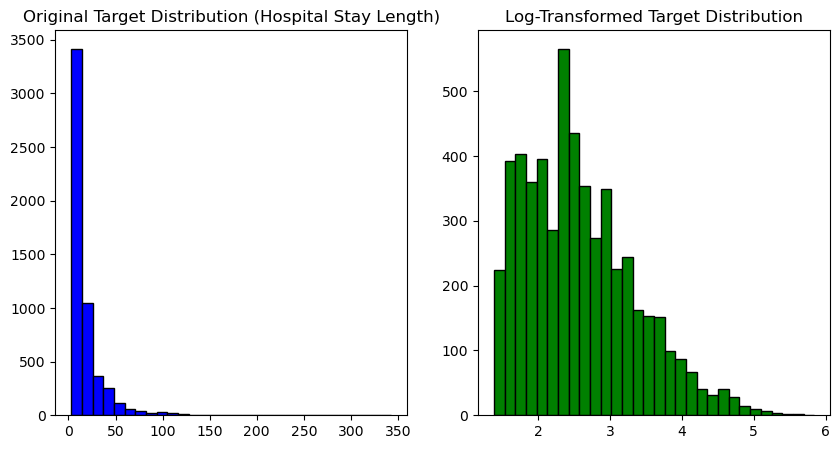

In [201]:
plt.figure(figsize=(10, 5))

# Histogram of original target values
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, color='blue', edgecolor='black')
plt.title('Original Target Distribution (Hospital Stay Length)')

# Histogram of log-transformed target values
plt.subplot(1, 2, 2)
plt.hist(np.log1p(y_train), bins=30, color='green', edgecolor='black')
plt.title('Log-Transformed Target Distribution')

plt.show()

In [51]:
# Log transformation of the target variable (log(1 + x) to handle zero values)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Fit the best ExtraTrees model on the log-transformed target
best_et_model.fit(X_train_imputed, y_train_log)

# Predict on the validation set
pred_log = best_et_model.predict(X_val_imputed)

# Inverse transformation (exp to bring predictions back to original scale)
pred_original_scale = np.expm1(pred_log)

# Calculate RMSE on the original scale
rmse = (root_mean_squared_error(y_val, pred_original_scale))
print(f"RMSE with log transformation: {rmse:.3f}")

# Plot actual vs predicted values
plot_actual_vs_pred(y_val, pred_original_scale, "ExtraTrees with Log Transformation")


RMSE with log transformation: 20.471


## Forsøker å trene modellen på ved å fjerne ekstreme uteliggere med over 95% 

## TODO: Fortsette å teste med flere variable, eventuelt forsøke å fjerne noen. Analysere RMSE, for å finne ut hvorfor den er som den er. Er det mulig at modellen er god, men at den misser stort på uteliggere?